# Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.metrics import f1_score, accuracy_score, \
roc_auc_score, classification_report, precision_score, recall_score, \
log_loss, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
#import shap

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

RAND = 42
N_FOLDS = 3

# Load data

In [7]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


# EDA

In [8]:
df_train = df_train.drop(columns=['Id'], axis=1)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

In [10]:
df_train.isna().sum()

AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [11]:
df_train.iloc[:,1:].describe()

,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,29.307300,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [12]:
df_train.describe(include=["object"])

,EJ
count,617
unique,2
top,B
freq,395


In [13]:
# 
le = LabelEncoder()
df_train["EJ"] = le.fit_transform(df_train["EJ"])

df_train.EJ.value_counts()

1    395
0    222
Name: EJ, dtype: int64

In [14]:
# filling in the gaps with the average value
for i in df_train.columns:
    col = df_train[i]
    col = col.fillna(col.mean() ,inplace=True) 
    
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      617 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      617 non-null    float64
 16  CC      617 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

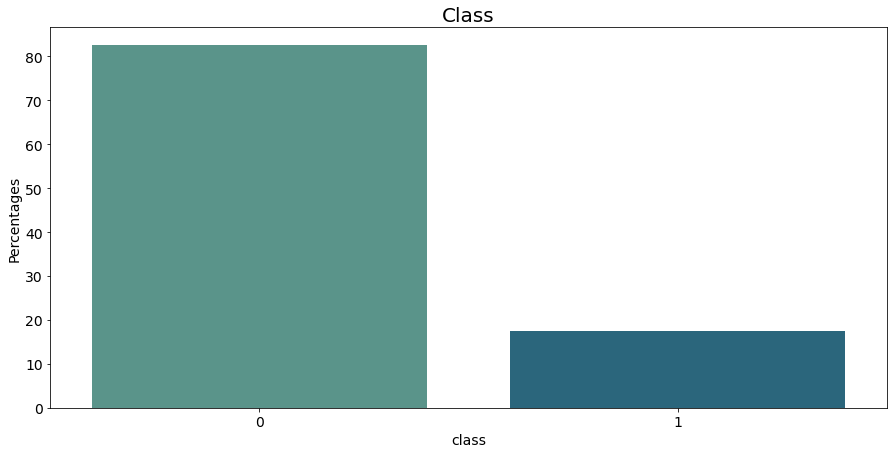

In [15]:
# rationing for the size of the dataset
norm_target = (df_train
               .Class
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

# checking the balance of classes
plt.figure(figsize=(15, 7))
sns.barplot(x='index', y='percent', data=norm_target, palette="crest")

plt.title('Class', fontsize=20)
plt.xlabel('class', fontsize=14)
plt.ylabel('Percentages', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

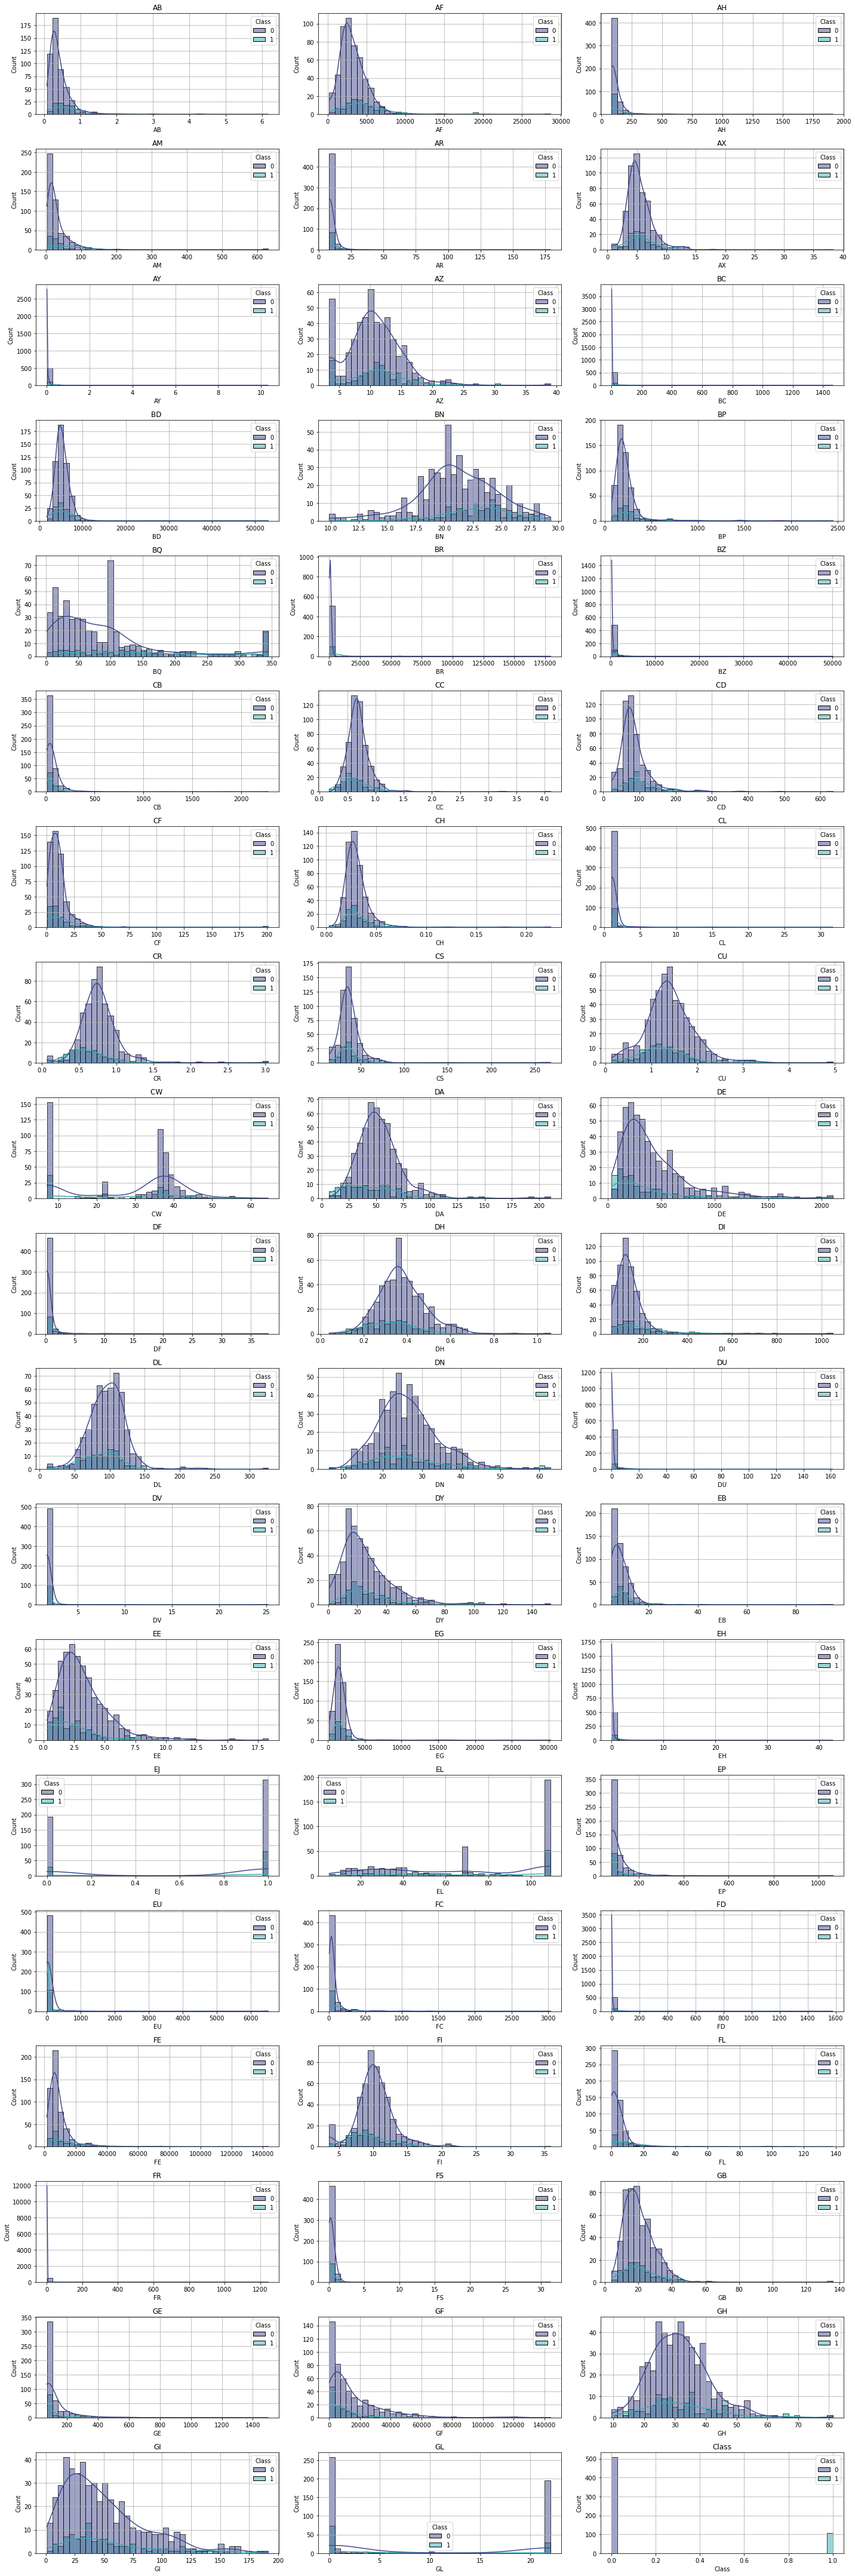

In [16]:
# checking the distribution of features and their outliers
cols = df_train.columns

fig, axes = plt.subplots(figsize=(20, 60))

for i in range(len(cols)):
    plt.subplot(19,3,i+1)
    sns.histplot(df_train,x=cols[i],hue="Class",bins=40,kde=True,palette="mako")
    plt.gca().set_title(cols[i])
    plt.grid(True)

fig.tight_layout()
plt.show()

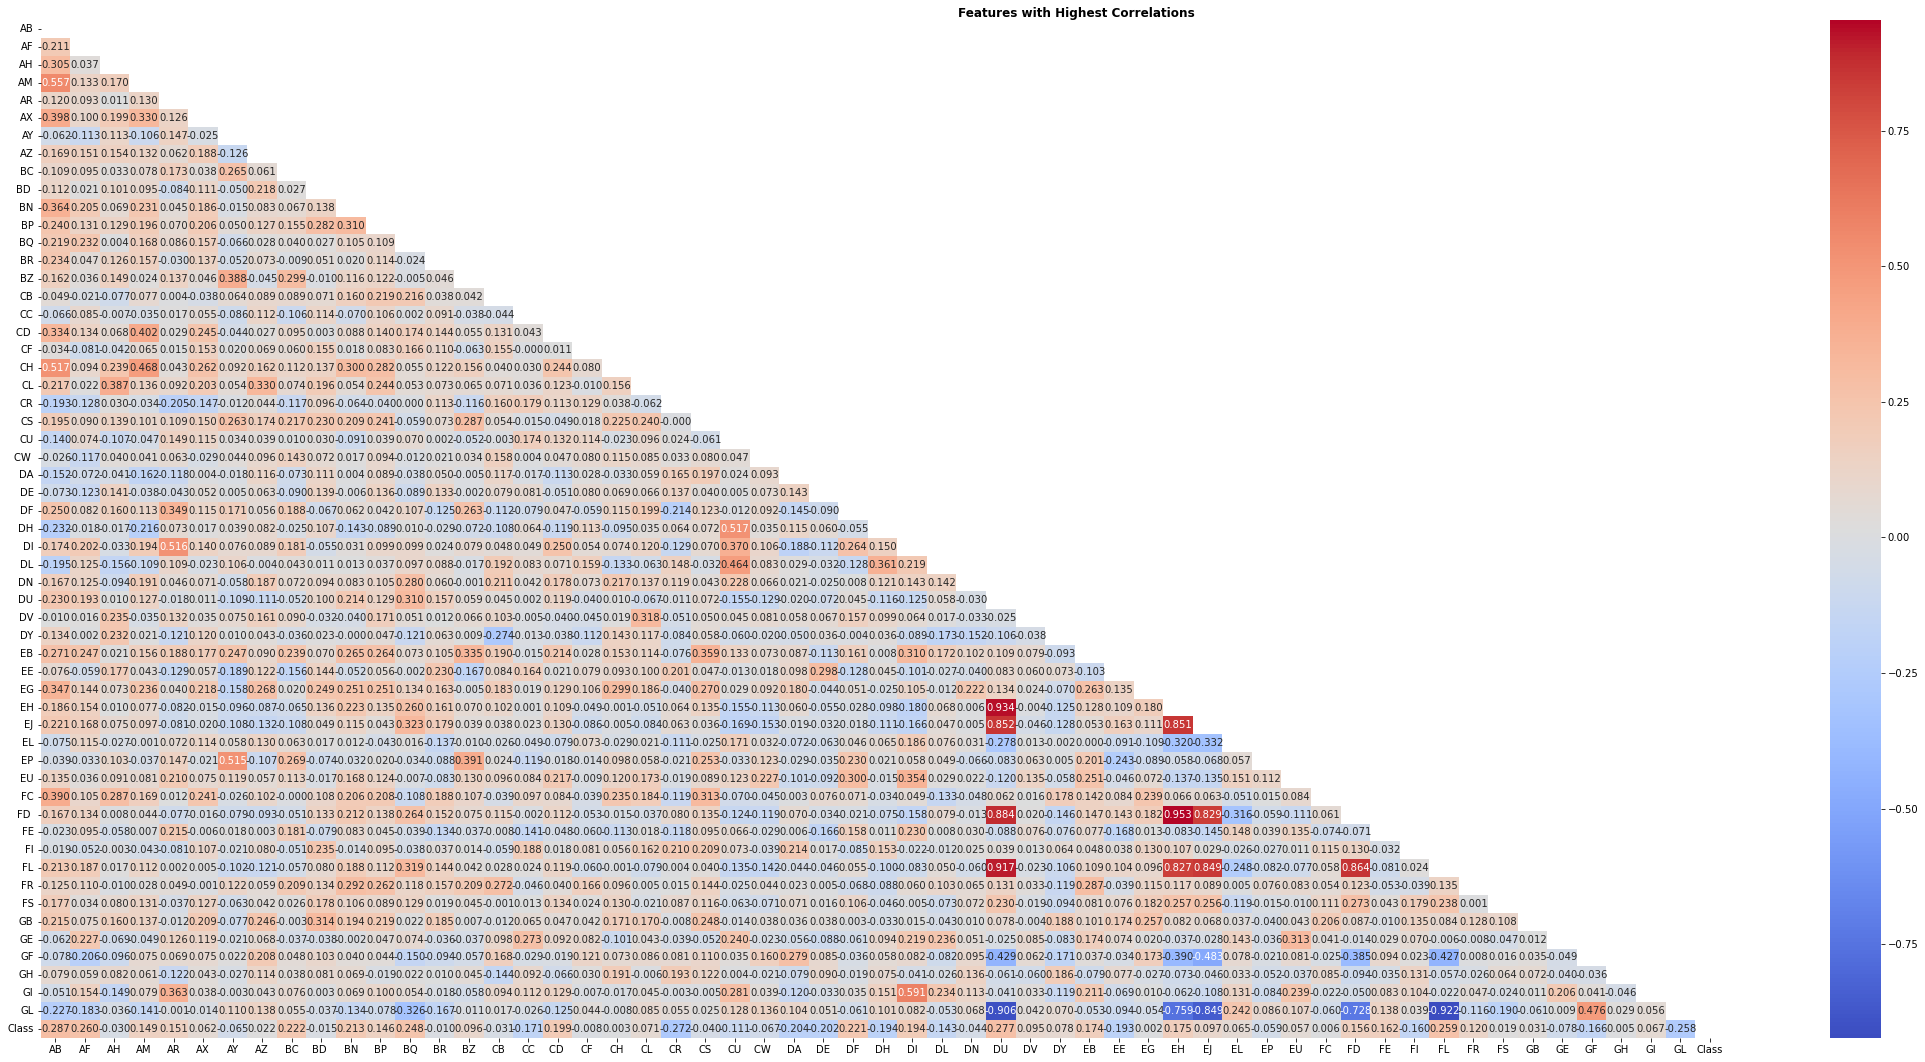

In [17]:
# checking the correlation between features and target

mask = np.triu(df_train.corr())

plt.figure(figsize=(30, 15))
sns.heatmap(df_train.corr(method='spearman'),
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations', weight='bold')
plt.tight_layout()

# Training Models

In [18]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [44]:
def get_metrics(y_test, y_pred, y_score, name):
    # displaying metrics
    
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['ROC_AUC'] = [roc_auc_score(y_test, y_score[:,1])]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    df_metrics['bal_log_loss'] = [balanced_log_loss(y_test, y_score[:,1])]
    
    return df_metrics

In [20]:
def check_overfitting(model, X_train, y_train, X_test, y_test):
    # check on overfitting
    
    y_pred_train = model.predict(X_train)
    y_prod_train = model.predict_proba(X_train)
    
    y_pred_test = model.predict(X_test)
    y_prod_test = model.predict_proba(X_test)
    

    print(f'ROC_AUC train: %.3f' % roc_auc_score(y_train, y_prod_train[:,1]))
    print(f'ROC_AUC test: %.3f' % roc_auc_score(y_test, y_prod_test[:,1]))

    print(f'F1 train: %.3f' % f1_score(y_train, y_pred_train))
    print(f'F1 test: %.3f' % f1_score(y_test, y_pred_test))

In [45]:
# splitting into training and test data

X = df_train.drop(['Class'], axis=1)
y = df_train['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RAND)

## LGBM CridSearchCV

In [46]:
parameters_grid = {
    'num_iterations': [100],
    'learning_rate': [0.001, 0.05, 0.1],
    'max_depth': [6, 10, 15],
    'num_leaves': [10],
    'is_unbalance': [True]
}

lgm = LGBMClassifier()
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

lgb_grid = GridSearchCV(lgm,
                        parameters_grid,
                        scoring='roc_auc',
                        cv=cv,
                        verbose=1)

lgb_grid.fit(X_train, y_train, verbose=0)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'is_unbalance': [True],
                         'learning_rate': [0.001, 0.05, 0.1],
                         'max_depth': [6, 10, 15], 'num_iterations': [100],
                         'num_leaves': [10]},
             scoring='roc_auc', verbose=1)

In [47]:
y_pred = lgb_grid.predict(X_test)
y_score = lgb_grid.predict_proba(X_test)

metrics = get_metrics(y_test, y_pred, y_score, 'LGBM_grid')
metrics

,model,ROC_AUC,f1,bal_log_loss
0,LGBM_grid,0.991467,0.931034,0.173293


In [48]:
check_overfitting(lgb_grid, X_train, y_train, X_test, y_test)

ROC_AUC train: 1.000
ROC_AUC test: 0.991
F1 train: 1.000
F1 test: 0.931


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       125
           1       0.96      0.90      0.93        30

    accuracy                           0.97       155
   macro avg       0.97      0.95      0.96       155
weighted avg       0.97      0.97      0.97       155



In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TN = {tn}\nFP = {fp}\nFN = {fn}\nTP = {tp}')

TN = 124
FP = 1
FN = 3
TP = 27


## CatBoost

In [51]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
ratio

4.923076923076923

In [52]:
cb = CatBoostClassifier(random_state=RAND,
                       scale_pos_weight=ratio)

cb.fit(X_train,
       y_train,
       verbose=False)

In [53]:
y_pred = cb.predict(X_test)
y_score = cb.predict_proba(X_test)

metrics = metrics.append(get_metrics(y_test, y_pred, y_score, 'CatBoost'))
metrics

,model,ROC_AUC,f1,bal_log_loss
0,LGBM_grid,0.991467,0.931034,0.173293
0,CatBoost,0.988267,0.915254,0.204463


In [54]:
check_overfitting(cb, X_train, y_train, X_test, y_test)

ROC_AUC train: 1.000
ROC_AUC test: 0.988
F1 train: 1.000
F1 test: 0.915


## CatBoost CridSearchCV

In [55]:
parameters_grid = {
    "iterations": [500],
    "learning_rate": [0.05, 0.03],
    #"depth": [8],
     "bootstrap_type" : ['No'],
    "scale_pos_weight": [ratio]
}

cb = CatBoostClassifier()
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

cb_grid = GridSearchCV(cb,
                        parameters_grid,
                        scoring='roc_auc',
                        cv=cv,
                        verbose=False)

cb_grid.fit(X_train, y_train, verbose=0)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000016777DE6940>,
             param_grid={'bootstrap_type': ['No'], 'iterations': [500],
                         'learning_rate': [0.05, 0.03],
                         'scale_pos_weight': [4.923076923076923]},
             scoring='roc_auc', verbose=False)

In [56]:
y_pred = cb_grid.predict(X_test)
y_score = cb_grid.predict_proba(X_test)

metrics = metrics.append(get_metrics(y_test, y_pred, y_score, 'Catboost_grid'))
metrics

,model,ROC_AUC,f1,bal_log_loss
0,LGBM_grid,0.991467,0.931034,0.173293
0,CatBoost,0.988267,0.915254,0.204463
0,Catboost_grid,0.992000,0.931034,0.156634


In [57]:
check_overfitting(cb_grid, X_train, y_train, X_test, y_test)

ROC_AUC train: 1.000
ROC_AUC test: 0.992
F1 train: 1.000
F1 test: 0.931


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       125
           1       0.96      0.90      0.93        30

    accuracy                           0.97       155
   macro avg       0.97      0.95      0.96       155
weighted avg       0.97      0.97      0.97       155



In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TN = {tn}\nFP = {fp}\nFN = {fn}\nTP = {tp}')

TN = 124
FP = 1
FN = 3
TP = 27


## XGBoost GridSearchCV

In [60]:
xgb_params = {
    'n_estimators': [100],
    'max_depth': [6, 8],
    'scale_pos_weight': [ratio],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.5, 0.7, 0.9],
    'tree_method': ['exact']
}

xgb_clf = XGBClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_xgb = GridSearchCV(xgb_clf,
                        param_grid=xgb_params,
                        scoring='roc_auc',
                        cv=cv,
                        n_jobs=-1,
                        verbose=0)

grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [6, 8], 'n_estimators': [100],
                         'scale_pos_weight': [4.923076923076923],
                         'subsample': [0.5, 0.7, 0.9],
                         'tree_method': ['exact']},
             scoring='roc_auc')

In [61]:
y_pred = grid_xgb.predict(X_test)
y_score = grid_xgb.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score,
                name='XGBoost_GridSearchCV'))

metrics

,model,ROC_AUC,f1,bal_log_loss
0,LGBM_grid,0.991467,0.931034,0.173293
0,CatBoost,0.988267,0.915254,0.204463
0,Catboost_grid,0.992000,0.931034,0.156634
0,XGBoost_GridSearchCV,0.989600,0.931034,0.175340


In [62]:
check_overfitting(grid_xgb, X_train, y_train, X_test, y_test)

ROC_AUC train: 1.000
ROC_AUC test: 0.990
F1 train: 1.000
F1 test: 0.931


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       125
           1       0.96      0.90      0.93        30

    accuracy                           0.97       155
   macro avg       0.97      0.95      0.96       155
weighted avg       0.97      0.97      0.97       155



In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TN = {tn}\nFP = {fp}\nFN = {fn}\nTP = {tp}')

TN = 124
FP = 1
FN = 3
TP = 27


# Voting Soft

In [65]:
vt_clf = VotingClassifier(estimators=[('ct', cb_grid),
                                      #('xgb', grid_xgb),
                                       ('lg', lgb_grid)],
                           voting='soft')

vt_clf.fit(X_train, y_train)

0:	learn: 0.6609655	total: 7.52ms	remaining: 3.75s
1:	learn: 0.6118475	total: 13.5ms	remaining: 3.35s
2:	learn: 0.5785389	total: 20.1ms	remaining: 3.34s
3:	learn: 0.5373577	total: 26ms	remaining: 3.22s
4:	learn: 0.5140136	total: 31.7ms	remaining: 3.14s
5:	learn: 0.4935026	total: 38.8ms	remaining: 3.19s
6:	learn: 0.4780041	total: 44.6ms	remaining: 3.14s
7:	learn: 0.4518896	total: 51.1ms	remaining: 3.14s
8:	learn: 0.4253302	total: 56.7ms	remaining: 3.09s
9:	learn: 0.4053093	total: 62.4ms	remaining: 3.06s
10:	learn: 0.3910786	total: 68.5ms	remaining: 3.04s
11:	learn: 0.3758623	total: 74.2ms	remaining: 3.02s
12:	learn: 0.3597323	total: 79.9ms	remaining: 2.99s
13:	learn: 0.3459639	total: 85.8ms	remaining: 2.98s
14:	learn: 0.3316712	total: 91.8ms	remaining: 2.97s
15:	learn: 0.3194028	total: 98.2ms	remaining: 2.97s
16:	learn: 0.3094076	total: 104ms	remaining: 2.95s
17:	learn: 0.3013955	total: 110ms	remaining: 2.94s
18:	learn: 0.2882237	total: 116ms	remaining: 2.94s
19:	learn: 0.2764803	total:

181:	learn: 0.0153652	total: 1.29s	remaining: 2.25s
182:	learn: 0.0152888	total: 1.3s	remaining: 2.25s
183:	learn: 0.0151323	total: 1.3s	remaining: 2.24s
184:	learn: 0.0149488	total: 1.31s	remaining: 2.24s
185:	learn: 0.0148399	total: 1.32s	remaining: 2.23s
186:	learn: 0.0147948	total: 1.32s	remaining: 2.22s
187:	learn: 0.0146425	total: 1.33s	remaining: 2.21s
188:	learn: 0.0145920	total: 1.34s	remaining: 2.2s
189:	learn: 0.0145461	total: 1.34s	remaining: 2.19s
190:	learn: 0.0143965	total: 1.35s	remaining: 2.19s
191:	learn: 0.0142632	total: 1.36s	remaining: 2.18s
192:	learn: 0.0140930	total: 1.37s	remaining: 2.17s
193:	learn: 0.0139277	total: 1.37s	remaining: 2.16s
194:	learn: 0.0138262	total: 1.38s	remaining: 2.16s
195:	learn: 0.0137308	total: 1.39s	remaining: 2.15s
196:	learn: 0.0136429	total: 1.39s	remaining: 2.14s
197:	learn: 0.0135199	total: 1.4s	remaining: 2.13s
198:	learn: 0.0133641	total: 1.4s	remaining: 2.12s
199:	learn: 0.0133311	total: 1.41s	remaining: 2.12s
200:	learn: 0.013

348:	learn: 0.0056124	total: 2.39s	remaining: 1.03s
349:	learn: 0.0055815	total: 2.4s	remaining: 1.03s
350:	learn: 0.0055659	total: 2.41s	remaining: 1.02s
351:	learn: 0.0055437	total: 2.41s	remaining: 1.01s
352:	learn: 0.0055285	total: 2.42s	remaining: 1.01s
353:	learn: 0.0055095	total: 2.46s	remaining: 1.01s
354:	learn: 0.0054803	total: 2.47s	remaining: 1.01s
355:	learn: 0.0054738	total: 2.48s	remaining: 1s
356:	learn: 0.0054437	total: 2.48s	remaining: 994ms
357:	learn: 0.0054279	total: 2.49s	remaining: 987ms
358:	learn: 0.0053774	total: 2.49s	remaining: 979ms
359:	learn: 0.0053637	total: 2.5s	remaining: 972ms
360:	learn: 0.0053457	total: 2.5s	remaining: 965ms
361:	learn: 0.0053397	total: 2.51s	remaining: 957ms
362:	learn: 0.0053204	total: 2.52s	remaining: 950ms
363:	learn: 0.0052932	total: 2.52s	remaining: 943ms
364:	learn: 0.0052786	total: 2.53s	remaining: 936ms
365:	learn: 0.0052507	total: 2.54s	remaining: 930ms
366:	learn: 0.0052344	total: 2.55s	remaining: 923ms
367:	learn: 0.0052

14:	learn: 0.3332322	total: 168ms	remaining: 5.42s
15:	learn: 0.3184997	total: 176ms	remaining: 5.34s
16:	learn: 0.3059496	total: 184ms	remaining: 5.23s
17:	learn: 0.2970681	total: 191ms	remaining: 5.12s
18:	learn: 0.2826486	total: 198ms	remaining: 5.02s
19:	learn: 0.2695686	total: 205ms	remaining: 4.93s
20:	learn: 0.2573225	total: 214ms	remaining: 4.89s
21:	learn: 0.2500860	total: 222ms	remaining: 4.83s
22:	learn: 0.2401933	total: 229ms	remaining: 4.74s
23:	learn: 0.2332866	total: 236ms	remaining: 4.68s
24:	learn: 0.2278719	total: 243ms	remaining: 4.61s
25:	learn: 0.2211229	total: 251ms	remaining: 4.57s
26:	learn: 0.2162769	total: 258ms	remaining: 4.51s
27:	learn: 0.2100386	total: 265ms	remaining: 4.46s
28:	learn: 0.2037476	total: 271ms	remaining: 4.41s
29:	learn: 0.1969128	total: 278ms	remaining: 4.36s
30:	learn: 0.1926086	total: 285ms	remaining: 4.31s
31:	learn: 0.1849548	total: 292ms	remaining: 4.26s
32:	learn: 0.1771644	total: 299ms	remaining: 4.23s
33:	learn: 0.1720848	total: 306

185:	learn: 0.0121299	total: 1.66s	remaining: 2.79s
186:	learn: 0.0120390	total: 1.66s	remaining: 2.78s
187:	learn: 0.0119432	total: 1.67s	remaining: 2.77s
188:	learn: 0.0117406	total: 1.69s	remaining: 2.77s
189:	learn: 0.0116183	total: 1.69s	remaining: 2.77s
190:	learn: 0.0115264	total: 1.7s	remaining: 2.75s
191:	learn: 0.0113949	total: 1.71s	remaining: 2.74s
192:	learn: 0.0112665	total: 1.72s	remaining: 2.73s
193:	learn: 0.0111847	total: 1.72s	remaining: 2.72s
194:	learn: 0.0110624	total: 1.73s	remaining: 2.71s
195:	learn: 0.0109457	total: 1.74s	remaining: 2.7s
196:	learn: 0.0108208	total: 1.75s	remaining: 2.69s
197:	learn: 0.0107011	total: 1.75s	remaining: 2.68s
198:	learn: 0.0105934	total: 1.76s	remaining: 2.67s
199:	learn: 0.0104681	total: 1.77s	remaining: 2.65s
200:	learn: 0.0103684	total: 1.78s	remaining: 2.64s
201:	learn: 0.0102371	total: 1.78s	remaining: 2.63s
202:	learn: 0.0101101	total: 1.79s	remaining: 2.62s
203:	learn: 0.0100397	total: 1.8s	remaining: 2.61s
204:	learn: 0.0

363:	learn: 0.0039013	total: 2.94s	remaining: 1.1s
364:	learn: 0.0038924	total: 2.94s	remaining: 1.09s
365:	learn: 0.0038703	total: 2.95s	remaining: 1.08s
366:	learn: 0.0038539	total: 2.96s	remaining: 1.07s
367:	learn: 0.0038415	total: 2.97s	remaining: 1.06s
368:	learn: 0.0038332	total: 2.97s	remaining: 1.05s
369:	learn: 0.0038176	total: 2.98s	remaining: 1.05s
370:	learn: 0.0038037	total: 2.99s	remaining: 1.04s
371:	learn: 0.0037863	total: 3s	remaining: 1.03s
372:	learn: 0.0037678	total: 3s	remaining: 1.02s
373:	learn: 0.0037464	total: 3.01s	remaining: 1.01s
374:	learn: 0.0037330	total: 3.02s	remaining: 1s
375:	learn: 0.0037180	total: 3.02s	remaining: 997ms
376:	learn: 0.0037051	total: 3.03s	remaining: 989ms
377:	learn: 0.0036905	total: 3.04s	remaining: 980ms
378:	learn: 0.0036829	total: 3.04s	remaining: 972ms
379:	learn: 0.0036701	total: 3.05s	remaining: 963ms
380:	learn: 0.0036626	total: 3.06s	remaining: 955ms
381:	learn: 0.0036431	total: 3.06s	remaining: 946ms
382:	learn: 0.0036359	

32:	learn: 0.1935371	total: 264ms	remaining: 3.74s
33:	learn: 0.1890692	total: 275ms	remaining: 3.77s
34:	learn: 0.1838349	total: 284ms	remaining: 3.77s
35:	learn: 0.1796911	total: 293ms	remaining: 3.77s
36:	learn: 0.1748389	total: 300ms	remaining: 3.76s
37:	learn: 0.1709924	total: 307ms	remaining: 3.73s
38:	learn: 0.1673328	total: 315ms	remaining: 3.72s
39:	learn: 0.1640915	total: 322ms	remaining: 3.7s
40:	learn: 0.1608653	total: 328ms	remaining: 3.68s
41:	learn: 0.1563855	total: 336ms	remaining: 3.66s
42:	learn: 0.1534763	total: 343ms	remaining: 3.65s
43:	learn: 0.1505169	total: 351ms	remaining: 3.64s
44:	learn: 0.1467510	total: 358ms	remaining: 3.62s
45:	learn: 0.1435298	total: 366ms	remaining: 3.61s
46:	learn: 0.1403869	total: 373ms	remaining: 3.59s
47:	learn: 0.1371375	total: 380ms	remaining: 3.58s
48:	learn: 0.1336008	total: 387ms	remaining: 3.56s
49:	learn: 0.1297952	total: 394ms	remaining: 3.55s
50:	learn: 0.1273175	total: 401ms	remaining: 3.53s
51:	learn: 0.1253117	total: 409m

202:	learn: 0.0132438	total: 1.57s	remaining: 2.3s
203:	learn: 0.0131324	total: 1.58s	remaining: 2.29s
204:	learn: 0.0130156	total: 1.58s	remaining: 2.28s
205:	learn: 0.0128824	total: 1.59s	remaining: 2.27s
206:	learn: 0.0127898	total: 1.6s	remaining: 2.26s
207:	learn: 0.0126884	total: 1.6s	remaining: 2.25s
208:	learn: 0.0125531	total: 1.61s	remaining: 2.24s
209:	learn: 0.0124581	total: 1.62s	remaining: 2.23s
210:	learn: 0.0123455	total: 1.62s	remaining: 2.22s
211:	learn: 0.0122104	total: 1.63s	remaining: 2.22s
212:	learn: 0.0121403	total: 1.64s	remaining: 2.21s
213:	learn: 0.0120352	total: 1.65s	remaining: 2.2s
214:	learn: 0.0118929	total: 1.66s	remaining: 2.19s
215:	learn: 0.0118105	total: 1.66s	remaining: 2.18s
216:	learn: 0.0117462	total: 1.67s	remaining: 2.17s
217:	learn: 0.0116374	total: 1.67s	remaining: 2.17s
218:	learn: 0.0115442	total: 1.68s	remaining: 2.16s
219:	learn: 0.0114702	total: 1.69s	remaining: 2.15s
220:	learn: 0.0113457	total: 1.69s	remaining: 2.14s
221:	learn: 0.01

369:	learn: 0.0052867	total: 2.87s	remaining: 1.01s
370:	learn: 0.0052602	total: 2.88s	remaining: 1s
371:	learn: 0.0052170	total: 2.88s	remaining: 993ms
372:	learn: 0.0052071	total: 2.89s	remaining: 985ms
373:	learn: 0.0051667	total: 2.9s	remaining: 977ms
374:	learn: 0.0051406	total: 2.91s	remaining: 969ms
375:	learn: 0.0051157	total: 2.92s	remaining: 963ms
376:	learn: 0.0050840	total: 2.93s	remaining: 955ms
377:	learn: 0.0050685	total: 2.94s	remaining: 947ms
378:	learn: 0.0050589	total: 2.94s	remaining: 939ms
379:	learn: 0.0050289	total: 2.95s	remaining: 931ms
380:	learn: 0.0050199	total: 2.96s	remaining: 923ms
381:	learn: 0.0049992	total: 2.96s	remaining: 916ms
382:	learn: 0.0049708	total: 2.97s	remaining: 907ms
383:	learn: 0.0049560	total: 2.98s	remaining: 899ms
384:	learn: 0.0049313	total: 2.98s	remaining: 891ms
385:	learn: 0.0049230	total: 2.99s	remaining: 883ms
386:	learn: 0.0049038	total: 3s	remaining: 875ms
387:	learn: 0.0048733	total: 3s	remaining: 867ms
388:	learn: 0.0048430	

39:	learn: 0.2479174	total: 276ms	remaining: 3.17s
40:	learn: 0.2449179	total: 283ms	remaining: 3.16s
41:	learn: 0.2399496	total: 289ms	remaining: 3.15s
42:	learn: 0.2343362	total: 295ms	remaining: 3.14s
43:	learn: 0.2318528	total: 302ms	remaining: 3.13s
44:	learn: 0.2280369	total: 308ms	remaining: 3.11s
45:	learn: 0.2229603	total: 314ms	remaining: 3.1s
46:	learn: 0.2190049	total: 321ms	remaining: 3.09s
47:	learn: 0.2147518	total: 327ms	remaining: 3.08s
48:	learn: 0.2104158	total: 334ms	remaining: 3.07s
49:	learn: 0.2070204	total: 340ms	remaining: 3.06s
50:	learn: 0.2041208	total: 347ms	remaining: 3.06s
51:	learn: 0.1998200	total: 354ms	remaining: 3.04s
52:	learn: 0.1970419	total: 361ms	remaining: 3.04s
53:	learn: 0.1943977	total: 367ms	remaining: 3.03s
54:	learn: 0.1915236	total: 374ms	remaining: 3.02s
55:	learn: 0.1887879	total: 381ms	remaining: 3.02s
56:	learn: 0.1862500	total: 388ms	remaining: 3.01s
57:	learn: 0.1835797	total: 394ms	remaining: 3s
58:	learn: 0.1809549	total: 401ms	r

206:	learn: 0.0321967	total: 1.59s	remaining: 2.25s
207:	learn: 0.0319533	total: 1.6s	remaining: 2.25s
208:	learn: 0.0317343	total: 1.61s	remaining: 2.24s
209:	learn: 0.0315093	total: 1.62s	remaining: 2.23s
210:	learn: 0.0311262	total: 1.63s	remaining: 2.23s
211:	learn: 0.0308649	total: 1.64s	remaining: 2.22s
212:	learn: 0.0305082	total: 1.64s	remaining: 2.21s
213:	learn: 0.0301503	total: 1.65s	remaining: 2.21s
214:	learn: 0.0298568	total: 1.66s	remaining: 2.2s
215:	learn: 0.0296493	total: 1.67s	remaining: 2.2s
216:	learn: 0.0294249	total: 1.68s	remaining: 2.19s
217:	learn: 0.0291135	total: 1.69s	remaining: 2.19s
218:	learn: 0.0289150	total: 1.7s	remaining: 2.18s
219:	learn: 0.0286443	total: 1.71s	remaining: 2.18s
220:	learn: 0.0283646	total: 1.72s	remaining: 2.17s
221:	learn: 0.0281602	total: 1.73s	remaining: 2.16s
222:	learn: 0.0278912	total: 1.74s	remaining: 2.16s
223:	learn: 0.0276188	total: 1.75s	remaining: 2.16s
224:	learn: 0.0274076	total: 1.76s	remaining: 2.15s
225:	learn: 0.02

368:	learn: 0.0114636	total: 2.94s	remaining: 1.04s
369:	learn: 0.0114288	total: 2.95s	remaining: 1.03s
370:	learn: 0.0113585	total: 2.96s	remaining: 1.03s
371:	learn: 0.0112505	total: 2.96s	remaining: 1.02s
372:	learn: 0.0111916	total: 2.97s	remaining: 1.01s
373:	learn: 0.0111778	total: 2.98s	remaining: 1s
374:	learn: 0.0111612	total: 2.99s	remaining: 996ms
375:	learn: 0.0111281	total: 3s	remaining: 989ms
376:	learn: 0.0110775	total: 3.01s	remaining: 981ms
377:	learn: 0.0110289	total: 3.02s	remaining: 973ms
378:	learn: 0.0110060	total: 3.02s	remaining: 965ms
379:	learn: 0.0109209	total: 3.03s	remaining: 958ms
380:	learn: 0.0108852	total: 3.04s	remaining: 950ms
381:	learn: 0.0108561	total: 3.05s	remaining: 942ms
382:	learn: 0.0108088	total: 3.06s	remaining: 934ms
383:	learn: 0.0107735	total: 3.07s	remaining: 926ms
384:	learn: 0.0107193	total: 3.07s	remaining: 918ms
385:	learn: 0.0106979	total: 3.08s	remaining: 911ms
386:	learn: 0.0106532	total: 3.09s	remaining: 903ms
387:	learn: 0.0106

44:	learn: 0.2172317	total: 470ms	remaining: 4.75s
45:	learn: 0.2130759	total: 481ms	remaining: 4.74s
46:	learn: 0.2093637	total: 493ms	remaining: 4.75s
47:	learn: 0.2042067	total: 503ms	remaining: 4.73s
48:	learn: 0.2006517	total: 518ms	remaining: 4.76s
49:	learn: 0.1976249	total: 532ms	remaining: 4.78s
50:	learn: 0.1923324	total: 545ms	remaining: 4.8s
51:	learn: 0.1897602	total: 556ms	remaining: 4.79s
52:	learn: 0.1867759	total: 567ms	remaining: 4.78s
53:	learn: 0.1839656	total: 578ms	remaining: 4.77s
54:	learn: 0.1804359	total: 588ms	remaining: 4.76s
55:	learn: 0.1767725	total: 598ms	remaining: 4.74s
56:	learn: 0.1733128	total: 610ms	remaining: 4.74s
57:	learn: 0.1704825	total: 622ms	remaining: 4.74s
58:	learn: 0.1674340	total: 632ms	remaining: 4.73s
59:	learn: 0.1642031	total: 642ms	remaining: 4.71s
60:	learn: 0.1611873	total: 655ms	remaining: 4.72s
61:	learn: 0.1583424	total: 679ms	remaining: 4.8s
62:	learn: 0.1556457	total: 689ms	remaining: 4.78s
63:	learn: 0.1533047	total: 699ms

213:	learn: 0.0289588	total: 2s	remaining: 2.67s
214:	learn: 0.0286965	total: 2.01s	remaining: 2.66s
215:	learn: 0.0283048	total: 2.02s	remaining: 2.66s
216:	learn: 0.0279021	total: 2.03s	remaining: 2.65s
217:	learn: 0.0277657	total: 2.04s	remaining: 2.64s
218:	learn: 0.0275911	total: 2.05s	remaining: 2.63s
219:	learn: 0.0273011	total: 2.05s	remaining: 2.61s
220:	learn: 0.0269104	total: 2.06s	remaining: 2.6s
221:	learn: 0.0265983	total: 2.07s	remaining: 2.59s
222:	learn: 0.0263699	total: 2.08s	remaining: 2.58s
223:	learn: 0.0261941	total: 2.08s	remaining: 2.57s
224:	learn: 0.0259759	total: 2.09s	remaining: 2.56s
225:	learn: 0.0257514	total: 2.1s	remaining: 2.55s
226:	learn: 0.0254893	total: 2.11s	remaining: 2.54s
227:	learn: 0.0251495	total: 2.12s	remaining: 2.52s
228:	learn: 0.0249297	total: 2.12s	remaining: 2.51s
229:	learn: 0.0245938	total: 2.13s	remaining: 2.5s
230:	learn: 0.0243593	total: 2.14s	remaining: 2.49s
231:	learn: 0.0241722	total: 2.15s	remaining: 2.48s
232:	learn: 0.0239

375:	learn: 0.0085812	total: 3.33s	remaining: 1.1s
376:	learn: 0.0085283	total: 3.34s	remaining: 1.09s
377:	learn: 0.0084959	total: 3.35s	remaining: 1.08s
378:	learn: 0.0084465	total: 3.36s	remaining: 1.07s
379:	learn: 0.0084154	total: 3.37s	remaining: 1.06s
380:	learn: 0.0083706	total: 3.37s	remaining: 1.05s
381:	learn: 0.0083230	total: 3.38s	remaining: 1.04s
382:	learn: 0.0082727	total: 3.39s	remaining: 1.03s
383:	learn: 0.0082401	total: 3.4s	remaining: 1.03s
384:	learn: 0.0081916	total: 3.41s	remaining: 1.02s
385:	learn: 0.0081444	total: 3.42s	remaining: 1.01s
386:	learn: 0.0081090	total: 3.42s	remaining: 1000ms
387:	learn: 0.0080795	total: 3.43s	remaining: 990ms
388:	learn: 0.0080402	total: 3.44s	remaining: 981ms
389:	learn: 0.0080110	total: 3.45s	remaining: 972ms
390:	learn: 0.0079884	total: 3.45s	remaining: 963ms
391:	learn: 0.0079595	total: 3.46s	remaining: 954ms
392:	learn: 0.0079093	total: 3.47s	remaining: 945ms
393:	learn: 0.0078673	total: 3.48s	remaining: 936ms
394:	learn: 0

54:	learn: 0.1962522	total: 441ms	remaining: 3.57s
55:	learn: 0.1934800	total: 450ms	remaining: 3.57s
56:	learn: 0.1913434	total: 461ms	remaining: 3.58s
57:	learn: 0.1878396	total: 470ms	remaining: 3.58s
58:	learn: 0.1842219	total: 479ms	remaining: 3.58s
59:	learn: 0.1819636	total: 487ms	remaining: 3.57s
60:	learn: 0.1790757	total: 495ms	remaining: 3.56s
61:	learn: 0.1758537	total: 506ms	remaining: 3.57s
62:	learn: 0.1731853	total: 514ms	remaining: 3.56s
63:	learn: 0.1697470	total: 522ms	remaining: 3.56s
64:	learn: 0.1667849	total: 532ms	remaining: 3.56s
65:	learn: 0.1650173	total: 539ms	remaining: 3.55s
66:	learn: 0.1620592	total: 547ms	remaining: 3.54s
67:	learn: 0.1603561	total: 554ms	remaining: 3.52s
68:	learn: 0.1579241	total: 562ms	remaining: 3.51s
69:	learn: 0.1556572	total: 571ms	remaining: 3.51s
70:	learn: 0.1533980	total: 580ms	remaining: 3.5s
71:	learn: 0.1520869	total: 588ms	remaining: 3.5s
72:	learn: 0.1492663	total: 596ms	remaining: 3.49s
73:	learn: 0.1465911	total: 605ms

217:	learn: 0.0312650	total: 1.8s	remaining: 2.32s
218:	learn: 0.0310260	total: 1.81s	remaining: 2.32s
219:	learn: 0.0306637	total: 1.81s	remaining: 2.31s
220:	learn: 0.0302575	total: 1.82s	remaining: 2.3s
221:	learn: 0.0299279	total: 1.83s	remaining: 2.29s
222:	learn: 0.0297082	total: 1.84s	remaining: 2.29s
223:	learn: 0.0295655	total: 1.85s	remaining: 2.28s
224:	learn: 0.0292673	total: 1.86s	remaining: 2.27s
225:	learn: 0.0290365	total: 1.87s	remaining: 2.26s
226:	learn: 0.0287371	total: 1.88s	remaining: 2.25s
227:	learn: 0.0283574	total: 1.88s	remaining: 2.25s
228:	learn: 0.0280321	total: 1.89s	remaining: 2.24s
229:	learn: 0.0277706	total: 1.9s	remaining: 2.23s
230:	learn: 0.0274428	total: 1.91s	remaining: 2.22s
231:	learn: 0.0271948	total: 1.92s	remaining: 2.21s
232:	learn: 0.0269120	total: 1.92s	remaining: 2.2s
233:	learn: 0.0266856	total: 1.93s	remaining: 2.2s
234:	learn: 0.0264683	total: 1.95s	remaining: 2.19s
235:	learn: 0.0262693	total: 1.96s	remaining: 2.19s
236:	learn: 0.026

381:	learn: 0.0106456	total: 2.91s	remaining: 900ms
382:	learn: 0.0105856	total: 2.92s	remaining: 892ms
383:	learn: 0.0105307	total: 2.93s	remaining: 884ms
384:	learn: 0.0104517	total: 2.93s	remaining: 877ms
385:	learn: 0.0104291	total: 2.94s	remaining: 869ms
386:	learn: 0.0103973	total: 2.95s	remaining: 860ms
387:	learn: 0.0103343	total: 2.95s	remaining: 852ms
388:	learn: 0.0102741	total: 2.96s	remaining: 844ms
389:	learn: 0.0102477	total: 2.96s	remaining: 837ms
390:	learn: 0.0102238	total: 2.97s	remaining: 829ms
391:	learn: 0.0102005	total: 2.98s	remaining: 821ms
392:	learn: 0.0101553	total: 2.98s	remaining: 812ms
393:	learn: 0.0101081	total: 2.99s	remaining: 804ms
394:	learn: 0.0100780	total: 3s	remaining: 796ms
395:	learn: 0.0100200	total: 3s	remaining: 789ms
396:	learn: 0.0099745	total: 3.01s	remaining: 781ms
397:	learn: 0.0099307	total: 3.01s	remaining: 773ms
398:	learn: 0.0098753	total: 3.02s	remaining: 765ms
399:	learn: 0.0098205	total: 3.03s	remaining: 757ms
400:	learn: 0.0097

53:	learn: 0.1325009	total: 425ms	remaining: 3.51s
54:	learn: 0.1288980	total: 433ms	remaining: 3.5s
55:	learn: 0.1264541	total: 442ms	remaining: 3.5s
56:	learn: 0.1249253	total: 449ms	remaining: 3.49s
57:	learn: 0.1227187	total: 457ms	remaining: 3.48s
58:	learn: 0.1201015	total: 464ms	remaining: 3.46s
59:	learn: 0.1181811	total: 471ms	remaining: 3.45s
60:	learn: 0.1156595	total: 478ms	remaining: 3.44s
61:	learn: 0.1136410	total: 485ms	remaining: 3.43s
62:	learn: 0.1118674	total: 492ms	remaining: 3.41s
63:	learn: 0.1095794	total: 499ms	remaining: 3.4s
64:	learn: 0.1071616	total: 506ms	remaining: 3.39s
65:	learn: 0.1052346	total: 514ms	remaining: 3.38s
66:	learn: 0.1036771	total: 521ms	remaining: 3.36s
67:	learn: 0.1019451	total: 527ms	remaining: 3.35s
68:	learn: 0.1003786	total: 535ms	remaining: 3.34s
69:	learn: 0.0984863	total: 543ms	remaining: 3.34s
70:	learn: 0.0964520	total: 552ms	remaining: 3.34s
71:	learn: 0.0947567	total: 561ms	remaining: 3.33s
72:	learn: 0.0928858	total: 570ms	

221:	learn: 0.0138814	total: 1.74s	remaining: 2.17s
222:	learn: 0.0137447	total: 1.74s	remaining: 2.17s
223:	learn: 0.0135647	total: 1.75s	remaining: 2.16s
224:	learn: 0.0134717	total: 1.76s	remaining: 2.15s
225:	learn: 0.0134078	total: 1.77s	remaining: 2.15s
226:	learn: 0.0133062	total: 1.78s	remaining: 2.14s
227:	learn: 0.0131757	total: 1.79s	remaining: 2.13s
228:	learn: 0.0130532	total: 1.79s	remaining: 2.12s
229:	learn: 0.0129332	total: 1.8s	remaining: 2.12s
230:	learn: 0.0128003	total: 1.81s	remaining: 2.11s
231:	learn: 0.0127104	total: 1.82s	remaining: 2.1s
232:	learn: 0.0125962	total: 1.82s	remaining: 2.09s
233:	learn: 0.0125411	total: 1.83s	remaining: 2.08s
234:	learn: 0.0124284	total: 1.84s	remaining: 2.08s
235:	learn: 0.0123314	total: 1.85s	remaining: 2.07s
236:	learn: 0.0121838	total: 1.86s	remaining: 2.06s
237:	learn: 0.0120790	total: 1.86s	remaining: 2.05s
238:	learn: 0.0119908	total: 1.87s	remaining: 2.04s
239:	learn: 0.0119051	total: 1.88s	remaining: 2.04s
240:	learn: 0.

388:	learn: 0.0051672	total: 3.09s	remaining: 881ms
389:	learn: 0.0051490	total: 3.1s	remaining: 874ms
390:	learn: 0.0051237	total: 3.1s	remaining: 866ms
391:	learn: 0.0051079	total: 3.13s	remaining: 861ms
392:	learn: 0.0050933	total: 3.14s	remaining: 854ms
393:	learn: 0.0050822	total: 3.15s	remaining: 846ms
394:	learn: 0.0050671	total: 3.15s	remaining: 838ms
395:	learn: 0.0050547	total: 3.16s	remaining: 831ms
396:	learn: 0.0050328	total: 3.17s	remaining: 823ms
397:	learn: 0.0050190	total: 3.18s	remaining: 815ms
398:	learn: 0.0049992	total: 3.19s	remaining: 807ms
399:	learn: 0.0049912	total: 3.2s	remaining: 799ms
400:	learn: 0.0049827	total: 3.21s	remaining: 791ms
401:	learn: 0.0049520	total: 3.21s	remaining: 784ms
402:	learn: 0.0049282	total: 3.22s	remaining: 776ms
403:	learn: 0.0049121	total: 3.23s	remaining: 768ms
404:	learn: 0.0049012	total: 3.24s	remaining: 760ms
405:	learn: 0.0048714	total: 3.25s	remaining: 752ms
406:	learn: 0.0048438	total: 3.26s	remaining: 744ms
407:	learn: 0.0

VotingClassifier(estimators=[('ct',
                              GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                           estimator=<catboost.core.CatBoostClassifier object at 0x0000016777DE6940>,
                                           param_grid={'bootstrap_type': ['No'],
                                                       'iterations': [500],
                                                       'learning_rate': [0.05,
                                                                         0.03],
                                                       'scale_pos_weight': [4.923076923076923]},
                                           scoring='roc_auc', verbose=False)),
                             ('lg',
                              GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                           estimator=LGBMClassifier(),
                                           param_grid={'is_unbalance': [True],
                                                       'learning_rate': [0.001,
                                                                         0.05,
                                                                         0.1],
                                                       'max_depth': [6, 10, 15],
                                                       'num_iterations': [100],
                                                       'num_leaves': [10]},
                                           scoring='roc_auc', verbose=1))],
                 voting='soft')

In [66]:
y_pred = vt_clf.predict(X_test)
y_score = vt_clf.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='Voting_soft'))
metrics

,model,ROC_AUC,f1,bal_log_loss
0,LGBM_grid,0.991467,0.931034,0.173293
0,CatBoost,0.988267,0.915254,0.204463
0,Catboost_grid,0.992000,0.931034,0.156634
0,XGBoost_GridSearchCV,0.989600,0.931034,0.175340
0,Voting_soft,0.993067,0.931034,0.154243


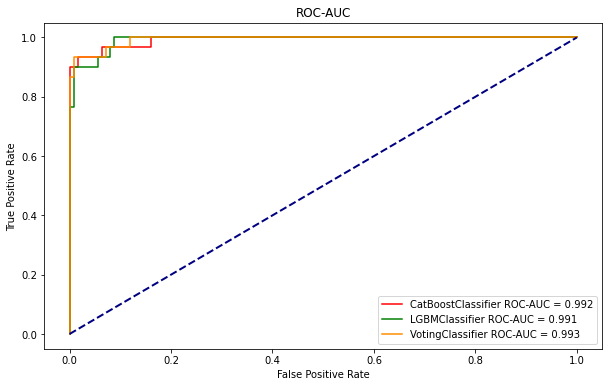

In [67]:
ct = cb_grid
lg = lgb_grid
plt.figure(figsize=(10, 6))

# CatBoost
plt.plot(roc_curve(y_test,
                   ct.predict_proba(X_test)[:, 1])[0],
         roc_curve(y_test,
                   ct.predict_proba(X_test)[:, 1])[1],
         color='red',
         label='CatBoostClassifier ROC-AUC = %0.3f' %
         roc_auc_score(y_test,
                       ct.predict_proba(X_test)[:, 1]))

# LGBM
plt.plot(roc_curve(y_test,
                   lg.predict_proba(X_test)[:, 1])[0],
         roc_curve(y_test,
                   lg.predict_proba(X_test)[:, 1])[1],
         color='green',
         label='LGBMClassifier ROC-AUC = %0.3f' %
         roc_auc_score(y_test,
                       lg.predict_proba(X_test)[:, 1]))

# VotingClassifier
plt.plot(roc_curve(y_test,
                   vt_clf.predict_proba(X_test)[:, 1])[0],
         roc_curve(y_test,
                   vt_clf.predict_proba(X_test)[:, 1])[1],
         color='darkorange',
         label='VotingClassifier ROC-AUC = %0.3f' %
         roc_auc_score(y_test,
                       vt_clf.predict_proba(X_test)[:, 1:]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

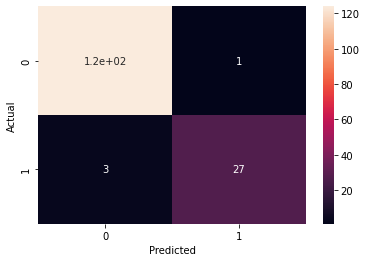

In [68]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [69]:
def features_importance(model, n_repeats=20):
    # checking the importance of features
    
    r = permutation_importance(model,
                               X_test,
                               y_test,
                               n_repeats=n_repeats,
                               random_state=RAND)

    feature_imp = pd.DataFrame()
    feature_imp['column'] = X_test.columns
    feature_imp['value'] = r['importances_mean']
    feature_imp['2_std'] = 2*r['importances_std']

    feature_imp.sort_values(by='value', inplace=True, ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(data=feature_imp[:15], x='value', y='column', palette='crest')
    
    return plt.show()

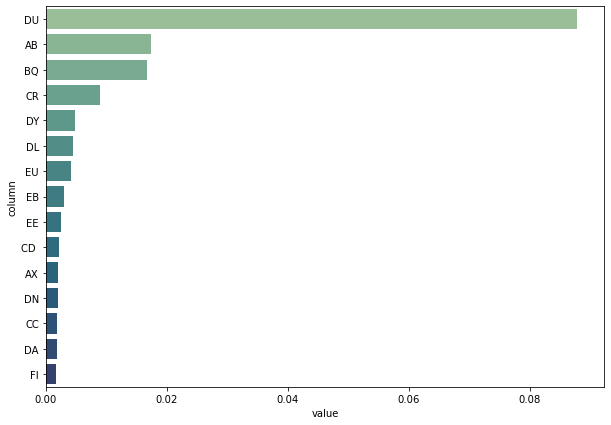

In [70]:
# let's check the importance of features on LGBM
features_importance(lgb_grid)

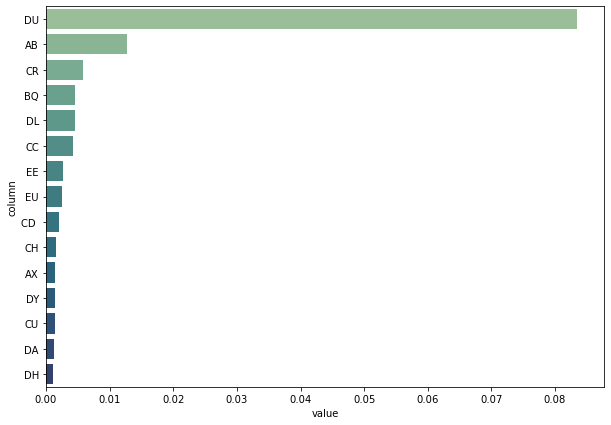

In [71]:
# let's check the importance of features on CatBoost
features_importance(cb_grid)

# Submission

In [72]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

In [73]:
test_ids = df_test['Id']
df_test = df_test.drop(['Id'], axis=1)

In [74]:
le=LabelEncoder()
df_test["EJ"]=le.fit_transform(df_test["EJ"])

In [75]:
y_score_test = vt_clf.predict_proba(df_test)

In [76]:
submission_df = pd.DataFrame({
    'Id': test_ids,
    'class_0': y_score_test[:, 0],  # Probability of Class 0 (No age-related condition)
    'class_1': y_score_test[:, 1],  # Probability of Class 1 (Age-related condition)
})

In [78]:
submission_df.to_csv('submission.csv', index = False)
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.911444,0.088556
1,010ebe33f668,0.911444,0.088556
2,02fa521e1838,0.911444,0.088556
3,040e15f562a2,0.911444,0.088556
4,046e85c7cc7f,0.911444,0.088556
